In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import os

In [2]:
data_path = "drive/MyDrive/data"
save_path = "drive/MyDrive/weight_save"
use_subdata = False

if use_subdata: #코드 검증용으로 일부 데이터만 가져오기

    from torch.utils.data import DataLoader, Subset
    import numpy as np

    transform = transforms.Compose([
        # transforms.Resize(224), # Image net에서는 224 고정인데 cifar는 학습 불안정
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    full_trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
    full_testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

    subset_indices_train = np.random.choice(len(full_trainset), 32*10, replace=False)
    subset_indices_test = np.random.choice(len(full_testset), 128, replace=False)

    trainset = Subset(full_trainset, subset_indices_train)
    testset = Subset(full_testset, subset_indices_test)

    batch_size = 32
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

else: # 전체 데이터 가져오기
    transform = transforms.Compose(
        [#transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

    batch_size = 64

    trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: drive/MyDrive/data/cifar-10-python.tar.gz
Extracting drive/MyDrive/data/cifar-10-python.tar.gz to drive/MyDrive/data
Files already downloaded and verified


In [3]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.second_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.third_block = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fourth_block = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fifth_block = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cls_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256), # 원래 512 * 7 * 7 이 입력인데 cifar라서 512 * 1 * 1이야
            nn.ReLU(),
            nn.Dropout(0.1), # 원래 논문은 50%인데, 임의로 10%로 바꿈
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10)
        )

    def loss(self, label, pred):
        score = F.log_softmax(pred, dim = -1) # -> torch.softmax -> loss nan 문제
        label = F.one_hot(label,num_classes = 10)
        cross_entropy = torch.mean(-torch.sum(label*score, dim = -1))

        return cross_entropy

    def save_weight(self, model, path, epoch):
        file_path = os.path.join(path, f"{epoch}_VGG16.pth")
        torch.save(model.state_dict(), file_path)
        print(f"Save Weight at {epoch}")

    def get_feature_maps(self, x):
        fmap1 = self.first_block(x)
        fmap2 = self.second_block(fmap1)
        fmap3 = self.third_block(fmap2)
        fmap4 = self.fourth_block(fmap3)
        fmap5 = self.fifth_block(fmap4)

        return fmap1, fmap2, fmap3, fmap4, fmap5

    def forward(self, x):
        x = self.first_block(x)
        x = self.second_block(x)
        x = self.third_block(x)
        x = self.fourth_block(x)
        x = self.fifth_block(x)
        x = self.cls_head(x)

        return x

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG().to(device)
import torchsummary
print("사용가능한 장치는?",device)
print(torchsummary.summary(model, (3, 32, 32)))


사용가능한 장치는? cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14 

In [5]:
epoch = 50
#optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9, weight_decay = 0.005)
optimizer = optim.AdamW(model.parameters(), lr=0.00025)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

train_loss_lst = []
train_accuracy_lst = []
test_loss_lst = []
test_accuracy_lst = []
patience = 0
for iter in range(epoch):
    train_loss = 0.0
    test_loss = 0.0
    train_accuracy_sum = 0
    test_accuracy_sum = 0

    # Training loop
    model.train()
    train_loader = tqdm(trainloader, desc=f"Epoch {iter+1} [Training]", leave=False)
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        best_pred = torch.argmax(outputs, dim = -1)
        correct = (best_pred == labels).sum().item()
        train_accuracy = correct / inputs.shape[0] * 100
        train_accuracy_sum += train_accuracy
        loss = model.loss(labels, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(trainloader)
    train_loss_lst.append(train_loss)

    model.eval()
    test_loader = tqdm(testloader, desc=f"Epoch {iter+1} [Testing]", leave=False)

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            best_pred = torch.argmax(outputs, dim = -1)
            correct = (best_pred == labels).sum().item()
            test_accuracy = correct / inputs.shape[0] * 100
            test_accuracy_sum += test_accuracy
            loss = model.loss(labels, outputs)
            test_loss += loss.item()

    test_loss /= len(testloader)
    test_loss_lst.append(test_loss)

    train_accuracy_mean = train_accuracy_sum / len(trainloader)
    train_accuracy_lst.append(train_accuracy_mean)

    test_accuracy_mean = test_accuracy_sum / len(testloader)
    test_accuracy_lst.append(test_accuracy_mean)

    if iter > 5:
        a = max(test_accuracy_lst[:-2])
        b = test_accuracy_lst[iter]
        print("a = {}, b = {}".format(a, b))
        if (a < b) or (iter%10 == 0):
            model.save_weight(model, save_path, iter)
        elif a >= b:
            patience += 1
            print("참을 인 몇 번? ", patience)

    if patience > 10:
        print("얼~리 스탑!")
        break

    scheduler.step()
    print(f"Epoch [{iter + 1}/{epoch}], Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}, train_acc: {train_accuracy_mean:.3f} %, test_acc: {test_accuracy_mean:.3f} % , Lr: {optimizer.param_groups[0]['lr']}")

print("Training Complete!")



Epoch [1/50], Train Loss: 1.898, Test Loss: 1.691, train_acc: 22.371 %, test_acc: 31.469 % , Lr: 0.00025


Epoch [2/50], Train Loss: 1.490, Test Loss: 1.292, train_acc: 41.202 %, test_acc: 51.841 % , Lr: 0.00025


Epoch [3/50], Train Loss: 1.167, Test Loss: 1.111, train_acc: 57.898 %, test_acc: 60.858 % , Lr: 0.00025


Epoch [4/50], Train Loss: 0.952, Test Loss: 0.923, train_acc: 66.598 %, test_acc: 68.322 % , Lr: 0.00025


Epoch [5/50], Train Loss: 0.805, Test Loss: 0.814, train_acc: 72.137 %, test_acc: 72.631 % , Lr: 0.00025


Epoch [6/50], Train Loss: 0.672, Test Loss: 0.755, train_acc: 77.066 %, test_acc: 75.070 % , Lr: 0.00025


a = 72.63136942675159, b = 76.93073248407643
Save Weight at 6
Epoch [7/50], Train Loss: 0.570, Test Loss: 0.734, train_acc: 80.814 %, test_acc: 76.931 % , Lr: 0.00025


a = 75.06966560509554, b = 77.72691082802548
Save Weight at 7
Epoch [8/50], Train Loss: 0.476, Test Loss: 0.687, train_acc: 84.269 %, test_acc: 77.727 % , Lr: 0.00025


a = 76.93073248407643, b = 79.1202229299363
Save Weight at 8
Epoch [9/50], Train Loss: 0.403, Test Loss: 0.717, train_acc: 86.539 %, test_acc: 79.120 % , Lr: 0.00025


a = 77.72691082802548, b = 79.33917197452229
Save Weight at 9
Epoch [10/50], Train Loss: 0.337, Test Loss: 0.700, train_acc: 88.803 %, test_acc: 79.339 % , Lr: 0.00015


a = 79.1202229299363, b = 81.23009554140127
Save Weight at 10
Epoch [11/50], Train Loss: 0.208, Test Loss: 0.756, train_acc: 93.201 %, test_acc: 81.230 % , Lr: 0.00015


a = 79.33917197452229, b = 80.80214968152866
Save Weight at 11
Epoch [12/50], Train Loss: 0.156, Test Loss: 0.815, train_acc: 94.805 %, test_acc: 80.802 % , Lr: 0.00015


a = 81.23009554140127, b = 81.01114649681529
참을 인 몇 번?  1
Epoch [13/50], Train Loss: 0.130, Test Loss: 0.866, train_acc: 95.830 %, test_acc: 81.011 % , Lr: 0.00015


a = 81.23009554140127, b = 80.29458598726114
참을 인 몇 번?  2
Epoch [14/50], Train Loss: 0.108, Test Loss: 0.945, train_acc: 96.531 %, test_acc: 80.295 % , Lr: 0.00015


a = 81.23009554140127, b = 80.51353503184713
참을 인 몇 번?  3
Epoch [15/50], Train Loss: 0.101, Test Loss: 0.899, train_acc: 96.743 %, test_acc: 80.514 % , Lr: 0.00015


a = 81.23009554140127, b = 80.4140127388535
참을 인 몇 번?  4
Epoch [16/50], Train Loss: 0.084, Test Loss: 0.965, train_acc: 97.396 %, test_acc: 80.414 % , Lr: 0.00015


a = 81.23009554140127, b = 80.42396496815287
참을 인 몇 번?  5
Epoch [17/50], Train Loss: 0.073, Test Loss: 0.956, train_acc: 97.716 %, test_acc: 80.424 % , Lr: 0.00015


a = 81.23009554140127, b = 81.31966560509554
Save Weight at 17
Epoch [18/50], Train Loss: 0.063, Test Loss: 0.995, train_acc: 97.990 %, test_acc: 81.320 % , Lr: 0.00015


a = 81.23009554140127, b = 80.96138535031847
참을 인 몇 번?  6
Epoch [19/50], Train Loss: 0.063, Test Loss: 1.021, train_acc: 98.072 %, test_acc: 80.961 % , Lr: 0.00015


a = 81.31966560509554, b = 81.17038216560509
참을 인 몇 번?  7
Epoch [20/50], Train Loss: 0.055, Test Loss: 0.988, train_acc: 98.282 %, test_acc: 81.170 % , Lr: 8.999999999999999e-05


a = 81.31966560509554, b = 81.32961783439491
Save Weight at 20
Epoch [21/50], Train Loss: 0.027, Test Loss: 1.342, train_acc: 99.253 %, test_acc: 81.330 % , Lr: 8.999999999999999e-05


a = 81.31966560509554, b = 81.60828025477707
Save Weight at 21
Epoch [22/50], Train Loss: 0.018, Test Loss: 1.411, train_acc: 99.457 %, test_acc: 81.608 % , Lr: 8.999999999999999e-05


a = 81.32961783439491, b = 81.55851910828025
Save Weight at 22
Epoch [23/50], Train Loss: 0.018, Test Loss: 1.392, train_acc: 99.465 %, test_acc: 81.559 % , Lr: 8.999999999999999e-05


a = 81.60828025477707, b = 81.50875796178345
참을 인 몇 번?  8
Epoch [24/50], Train Loss: 0.021, Test Loss: 1.365, train_acc: 99.373 %, test_acc: 81.509 % , Lr: 8.999999999999999e-05


a = 81.60828025477707, b = 81.45899681528662
참을 인 몇 번?  9
Epoch [25/50], Train Loss: 0.021, Test Loss: 1.310, train_acc: 99.387 %, test_acc: 81.459 % , Lr: 8.999999999999999e-05


a = 81.60828025477707, b = 81.57842356687898
참을 인 몇 번?  10
Epoch [26/50], Train Loss: 0.015, Test Loss: 1.347, train_acc: 99.602 %, test_acc: 81.578 % , Lr: 8.999999999999999e-05


a = 81.60828025477707, b = 81.45899681528662
참을 인 몇 번?  11
얼~리 스탑!
Training Complete!


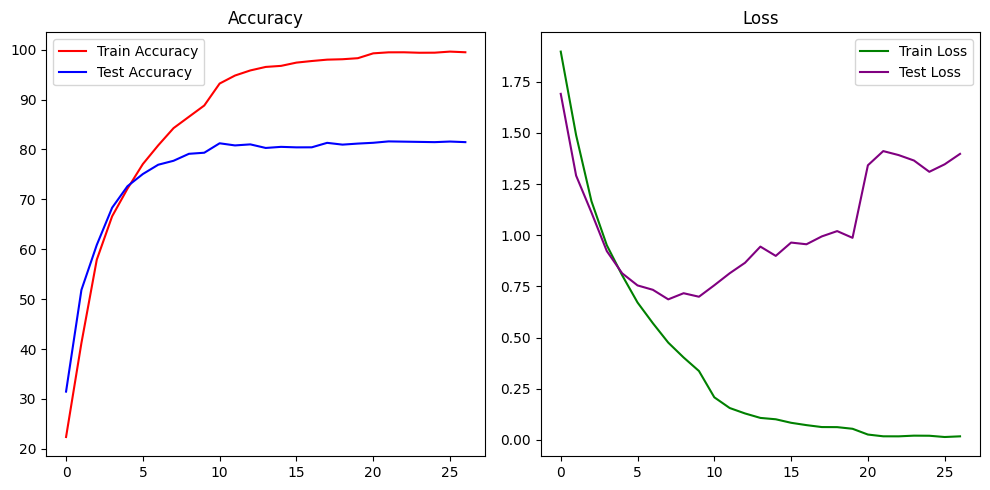

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_lst, 'r', label="Train Accuracy")
plt.plot(test_accuracy_lst, 'b', label="Test Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_loss_lst, 'g', label="Train Loss")
plt.plot(test_loss_lst, 'purple', label="Test Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()


In [7]:
load_weight = save_path + "/" + "22_VGG16.pth"
model = VGG()
model.load_state_dict(torch.load(load_weight, weights_only=True))
model = model.to(device)


In [ ]:
top_1_acc = 0 # 확률 제일 높은 class가 정답인가?
top_5_acc = 0 # 확률 상위 5개의 class중에서 정답이 있나?

# 구현 이상해

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _,top_one_prediction = torch.topk(outputs, k = 1, dim = -1)
        _,top_five_prediction = torch.topk(outputs, k=5, dim=1)

        top_1_acc += (top_one_prediction == labels).sum().item()
        top_5_acc += sum([labels[i].item() in top_five_prediction[i].tolist() for i in range(labels.size(0))])
num_of_data = 100#len(test_loader.dataset)
top_1_acc = (top_1_acc/num_of_data) * 100
top_5_acc = (top_5_acc/num_of_data) * 100

print("top 1 = {} %, top 5 = {} %".format(top_1_acc, top_5_acc))

top 1 = 378.0 %, top 5 = 96.0 %


In [30]:
# loss land scape를 구해보자
# https://cocoa-t.tistory.com/entry/PyHessian-Loss-Landscape-%EC%8B%9C%EA%B0%81%ED%99%94-PyHessian-Neural-Networks-Through-the-Lens-of-the-Hessian
# https://github.com/tabtoyou/3D-PyHessian/blob/master/Hessian_Tutorial.ipynb
from pyhessian import hessian
import numpy as np

def get_params(model_orig, model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d.to(m_orig.device)  # 장치 일치
    return model_perb


# 여기부터 연산 엄청 오래 걸림
criterion = nn.CrossEntropyLoss()
hessian_comp = hessian(model, criterion, data=(inputs, labels), cuda=True)
eigvals, eigvecs = hessian_comp.eigenvalues(top_n=2)


lams1 = np.linspace(-1, 1, 21).astype(np.float32)
lams2 = np.linspace(-1, 1, 21).astype(np.float32)

loss_lst = []

model_2 = VGG()
model_2.load_state_dict(torch.load(load_weight, weights_only=True))
model_2 = model.to(device)

model_3 = VGG()
model_3.load_state_dict(torch.load(load_weight, weights_only=True))
model_3 = model.to(device)

model.eval()
model_2.eval()
model_3.eval()

for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_2, eigvecs[0], lam1)
        model_perb2 = get_params(model_2, model_3, eigvecs[1], lam2)

        loss = criterion(model_3(inputs), labels).item()
        loss_lst.append((lam1, lam2, loss))

# numpy 배열로 변환
loss_lst = np.array(loss_lst)

<ipython-input-32-b346c2f42e89>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  landscape.dist = 6


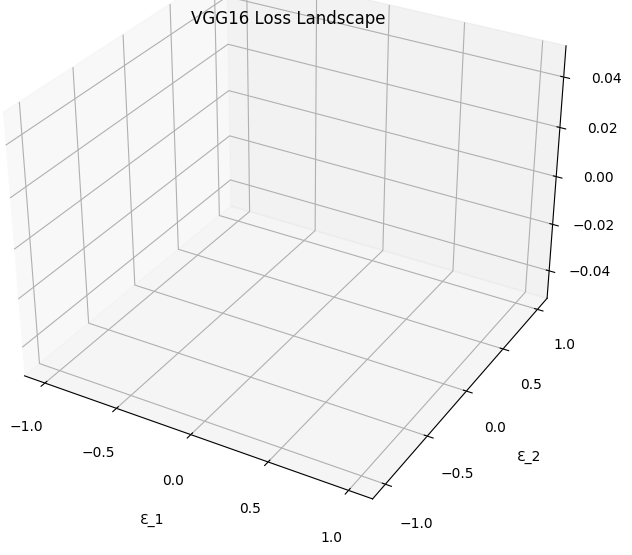

In [32]:
# loss landscape를 그려보자
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
landscape = fig.add_subplot(111, projection='3d')

landscape.plot_trisurf(
    loss_lst[:, 0], loss_lst[:, 1], loss_lst[:, 2],
    alpha=0.8, cmap='viridis'
)

landscape.set_title("VGG16 Loss Landscape")
landscape.set_xlabel("Ɛ_1")
landscape.set_ylabel("Ɛ_2")
landscape.set_zlabel("Loss")

#landscape.view_init(elev = 15, azim = 100)
landscape.dist = 6
plt.show()

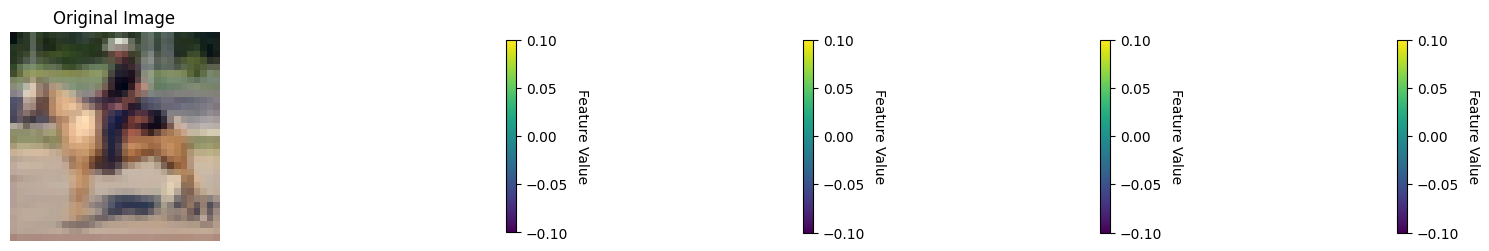

class_name is horse, model predits = plane


In [34]:
# CNN Layer별로 어떤 feature를 볼까?
fmap1, fmap2, fmap3, fmap4, fmap5 = model.get_feature_maps(inputs) # (batch, feature, size, size)
prediction = model.forward(inputs)


original_image = [inputs[0, :, :, :]]
truth_class_name = classes[labels[0]]
predict_class_name = classes[torch.argmax(prediction[0])]

fmap1 = fmap1[0, :, :, :].sum(dim = 0).detach().cpu().numpy() # [batch, 64, 16, 16] -> [16, 16]
fmap2 = fmap2[0, :, :, :].sum(dim = 0).detach().cpu().numpy() # [batch, 128, 8, 8] -> [8, 8]
fmap3 = fmap3[0, :, :, :].sum(dim = 0).detach().cpu().numpy() # [batch, 256, 4, 4] -> [4, 4]
fmap4 = fmap4[0, :, :, :].sum(dim = 0).detach().cpu().numpy() # [batch, 512, 2, 2] -> [2, 2]
#fmap5 = fmap5[0, :, :, :].sum(dim = 0).cpu().numpy() # [batch, 512, 1, 1] -> [1, 1]

def normalize_feature_map(fmap):
    fmap_min, fmap_max = fmap.min(), fmap.max()
    return (fmap - fmap_min) / (fmap_max - fmap_min)

fmap1, fmap2, fmap3, fmap4 = map(normalize_feature_map, [fmap1, fmap2, fmap3, fmap4])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

original_image = inputs[0].detach().cpu().permute(1, 2, 0).numpy()
original_image = normalize_feature_map(original_image)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

feature_maps = [fmap1, fmap2, fmap3, fmap4]
for i, fmap in enumerate(feature_maps):
    im = axes[i + 1].imshow(fmap, cmap='viridis')
    axes[i + 1].axis('off')
    cbar = fig.colorbar(im, ax=axes[i + 1], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Value', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

print("class_name is {}, model predits = {}".format(truth_class_name, predict_class_name))